## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [45]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import random

from itertools import chain
from random import sample 
import scipy
import sklearn.model_selection as skl
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.optimizers import Adam
from keras.layers import GlobalMaxPooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
17196,00004608_008.png,Effusion|Infiltration,8,4608,62,M,PA,2992,2991,0.143,0.143,NaN,/data/images_003/images/00004608_008.png
75221,00018454_000.png,Nodule,0,18454,47,F,PA,2992,2991,0.143,0.143,NaN,/data/images_009/images/00018454_000.png
102171,00027213_001.png,No Finding,1,27213,73,F,AP,3056,2544,0.139,0.139,NaN,/data/images_011/images/00027213_001.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All labels ({}): {}'.format(len(all_labels), all_labels))

for c_label in all_labels:
    if len(c_label)>1:
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
62881,00015551_005.png,No Finding,5,15551,53,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
71688,00017655_001.png,Nodule,1,17655,32,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
596,00000147_001.png,Atelectasis,1,147,66,F,PA,2742,2948,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

#Change 1 to Yes and 0 to No in a new pneumonia class column
all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia'].apply(lambda x: 'Yes' if x == 1 else 'No')
all_xray_df = all_xray_df[(all_xray_df['Patient Age'] <=100)]
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
77406,00019018_008.png,Cardiomegaly|Consolidation|Effusion|Infiltrati...,8,19018,28,M,AP,3056,2544,0.139,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,No
70424,00017362_020.png,Cardiomegaly|Effusion|Pleural_Thickening,20,17362,53,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,No
89488,00022215_002.png,Atelectasis|Infiltration,2,22215,53,F,PA,2992,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,No


## Create your training and testing data:

In [48]:
def create_splits(df, test_size, column):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    train_data, val_data = skl.train_test_split(df, test_size = test_size, stratify = df[column])
    
    
    #dividing data in equal representation of Pneumonia
    #training data
    p_ind = train_data[train_data['pneumonia_class']== 'Yes'].index.tolist()
    n_ind = train_data[train_data['pneumonia_class']== 'No'].index.tolist()
    
    np_sample = random.sample(n_ind, len(p_ind))
    train_data = train_data.loc[p_ind + np_sample]
    
    #validation data
    vp_ind = val_data[val_data['pneumonia_class']== 'Yes'].index.tolist()
    vn_ind = val_data[val_data['pneumonia_class']== 'No'].index.tolist()
    
    vnp_sample = random.sample(vn_ind, 4*len(vp_ind))
    val_data = val_data.loc[vp_ind + vnp_sample]
    
    #Check amount of positive cases
    print('Train dataset has {} images, with {:0.1%} positive images ({}).'.format(
        len(train_data), len(p_ind)/len(train_data), len(p_ind)))
    print('Test dataset has {} images, with {:0.1%} positive images ({}).'.format(
        len(val_data), len(vp_ind)/len(val_data), len(vp_ind)))
    
    return train_data, val_data

In [49]:
#Running the defined function 
train_data, val_data = create_splits(all_xray_df, 0.2,'pneumonia_class')

Train dataset has 2288 images, with 50.0% positive images (1144).
Test dataset has 1430 images, with 20.0% positive images (286).


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [60]:
def train_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    my_train_idg = ImageDataGenerator(rescale=1. / 255.0,
                               horizontal_flip = True,
                               vertical_flip = False,
                               height_shift_range= 0,
                               width_shift_range=0.1, 
                               rotation_range=10, 
                               shear_range = 0.05,
                               zoom_range=0.05
                               )
    
    return my_train_idg


def make_train_gen(train_data, img_size, batch_size):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    idg = train_image_augmentation()
    train_gen = idg.flow_from_dataframe(dataframe=train_data,
                                                 directory=None,
                                                 x_col = 'path' ,
                                                 y_col = 'pneumonia_class',
                                                 class_mode = 'binary',
                                                 target_size = img_size,
                                                 batch_size = batch_size,
                                                 shuffle = True,
                                                 seed = 42
                                                )
     

    return train_gen


def make_val_gen(valid_data, img_size, batch_size):
    
    val_idg = ImageDataGenerator(rescale=1. / 255.0)
    val_gen = val_idg.flow_from_dataframe(dataframe = val_data,
                                             directory=None,
                                             x_col = 'path',
                                             y_col = 'pneumonia_class',
                                             class_mode = 'binary',
                                             target_size = (224,224), 
                                             batch_size = batch_size,
                                             shuffle = False,
                                             seed = 42
                                            ) 
    
    return val_gen

In [61]:
#Run augmentation and split of data
img_size = (224, 224)
batch_size = 16

train_gen = make_train_gen(train_data, img_size, batch_size)
val_gen = make_val_gen(val_data, img_size, batch_size)

Found 2288 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [52]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

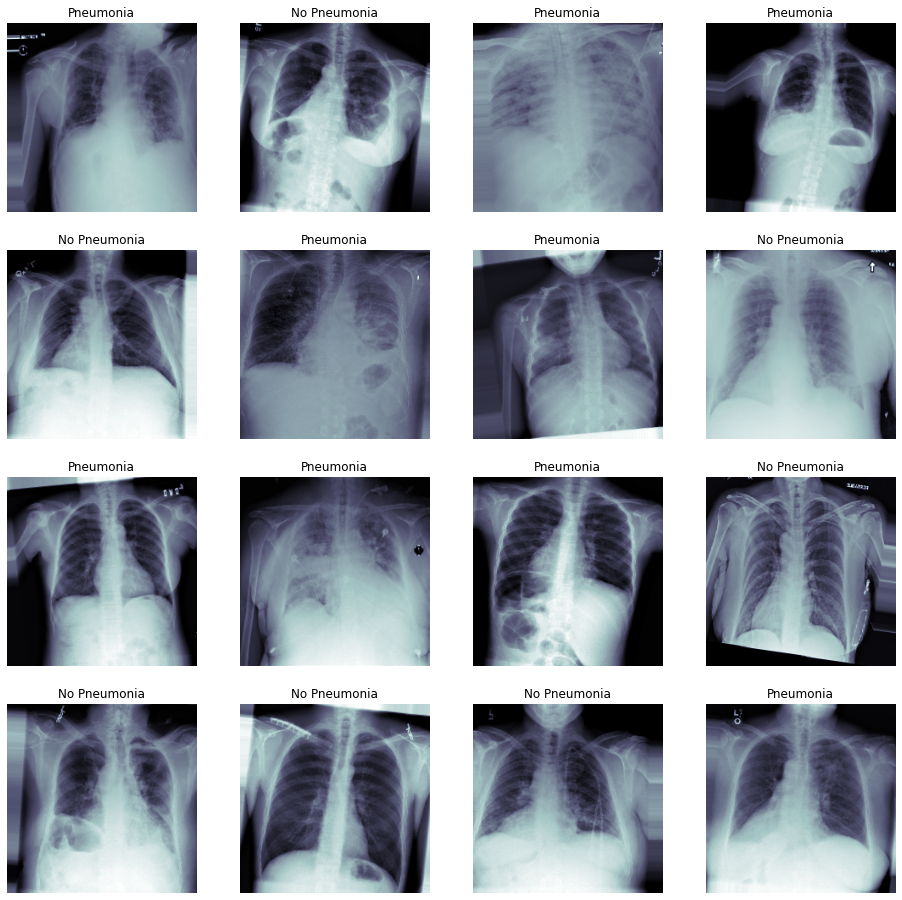

In [53]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [62]:
 # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatten, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
def build_model(finetune=15):
    
    #Use Vggg as base model
    vgg_model = VGG16(include_top=False, weights='imagenet', input_shape = (224, 224, 3))
    
    if finetune > 0:
        for layer in vgg_model.layers[0:finetune]:
            layer.trainable = False
    else:
        for layer in vgg_model.layers:
            layer.trainable = True
    
    transfer_layer = vgg_model.get_layer('block5_pool')
    outputs = transfer_layer.output
    
    x = Flatten()(outputs)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)
    
    optimizer = Adam(lr=1e-4)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    
    my_model = Model(vgg_model.input, x)
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    my_model.summary()
    
    for layer in my_model.layers:
        print('Layer {} Trainable {}'.format(layer.name, layer.trainable))
        
    return my_model

In [63]:
my_model = build_model()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [64]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                              monitor= 'val_loss', 
                              verbose=1, 
                              save_best_only=True, 
                              mode= 'min', 
                              save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                       mode= 'min', 
                       patience=5)

adjustlr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

callbacks_list = [checkpoint, early, adjustlr]

### Start training! 

In [65]:
## train your model

# Todo

history = my_model.fit_generator(train_gen, 
                           validation_data = (valX, valY), 
                           epochs = 20, 
                           callbacks = callbacks_list)

Epoch 1/20
143/143 [==============================] - 73s 509ms/step - loss: 0.7445 - binary_accuracy: 0.5214 - val_loss: 0.6010 - val_binary_accuracy: 0.7161

Epoch 00001: val_loss improved from inf to 0.60097, saving model to xray_class_my_model.best.hdf5
Epoch 2/20
143/143 [==============================] - 69s 480ms/step - loss: 0.6899 - binary_accuracy: 0.5472 - val_loss: 0.6919 - val_binary_accuracy: 0.6238

Epoch 00002: val_loss did not improve from 0.60097
Epoch 3/20
143/143 [==============================] - 68s 476ms/step - loss: 0.6723 - binary_accuracy: 0.5997 - val_loss: 0.6726 - val_binary_accuracy: 0.5818

Epoch 00003: val_loss did not improve from 0.60097
Epoch 4/20
143/143 [==============================] - 68s 474ms/step - loss: 0.6656 - binary_accuracy: 0.6018 - val_loss: 0.6255 - val_binary_accuracy: 0.6629

Epoch 00004: val_loss did not improve from 0.60097
Epoch 5/20
143/143 [==============================] - 67s 471ms/step - loss: 0.6664 - binary_accuracy: 0.6066

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [66]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 64, verbose = True)

1430/1430 [==============================] - 16s 11ms/step


In [67]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    fig, c_ax = plt.subplots(1,1, figsize=(9,9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)' %('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive rate')
    c_ax.set_ylabel('True Positive rate')
    plt.show()
    
    return

## what other performance statistics do you want to include here besides AUC? 


def plot_precision_recall_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize=(9,9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)' % ('Pneumonia', average_precision_score(t_y, p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')
    plt.show()

def calc_f1(prec, recall):
    return 2*(prec*recall) / (prec+recall)
# Todo
    
#Also consider plotting the history of your model training:

def plot_history(history):
    
    n = len(history.history["loss"])
    plt.figure()
    plt.plot(np.arange(n), history.history["loss"], label="train_loss")
    plt.plot(np.arange(n), history.history["val_loss"], label="val_loss")
    plt.title("Training Loss on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc = "upper right")
    return

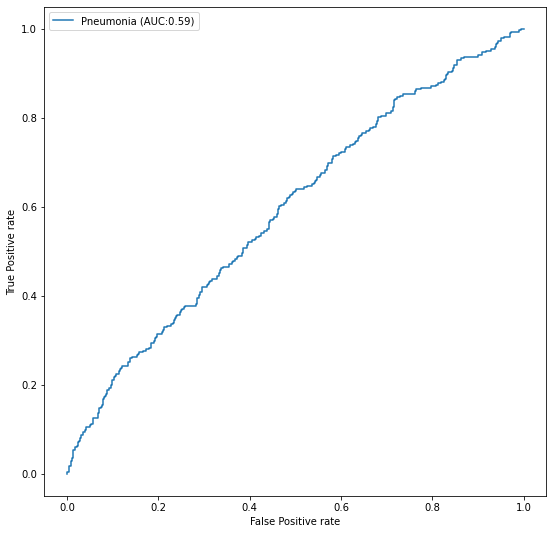

In [68]:
## plot figures

plot_auc(valY, pred_Y)

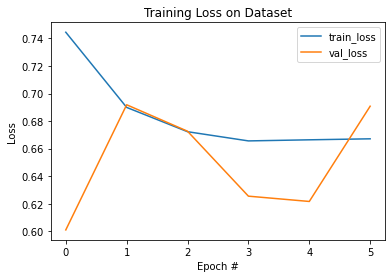

In [69]:
plot_history(history)

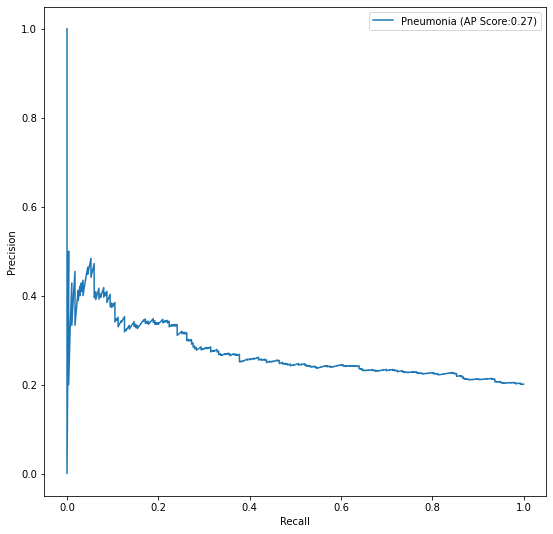

In [70]:
plot_precision_recall_curve(valY, pred_Y)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [87]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

precision, recall, thresholds = precision_recall_curve(valY, pred_Y)

precision_value = 0.5
idx1 = (np.abs(precision - precision_value)).argmin()
print('Precision is:' + str(precision[idx1]))
print('Recall is:' + str(recall[idx1]))
print('Threshold is:' + str(thresholds[idx1]))
print('F1 score is' + str(calc_f1(precision[idx1], recall[idx1])))
threshold1 = thresholds[idx1]

Precision is:0.5
Recall is:0.0034965034965034965
Threshold is:0.6355001
F1 score is0.006944444444444444


In [88]:
recall_value = 0.8
idx2 = (np.abs(recall - recall_value)).argmin()
print('Precision is:' + str(precision[idx2]))
print('Recall is:' + str(recall[idx2]))
print('Threshold is:' + str(thresholds[idx2]))
print('F1 score is:' + str(calc_f1(precision[idx2], recall[idx2])))
threshold2 = thresholds[idx2]

Precision is:0.22561576354679802
Recall is:0.8006993006993007
Threshold is:0.35410103
F1 score is:0.3520368946963874


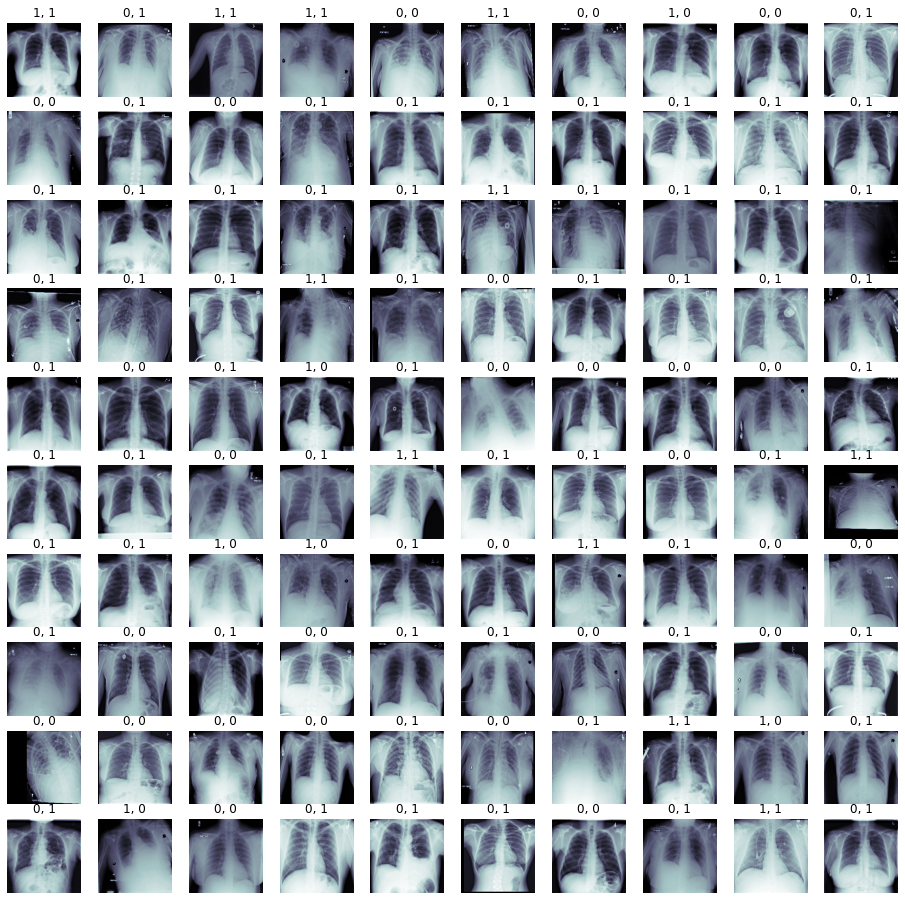

In [91]:
## Let's look at some examples of true vs. predicted with our best model: 

threshold = threshold2

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[250:350], valY[250:350], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > threshold:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > threshold: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [92]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)